# Análise Experimental do Sistema de Consultas Logísticas (v2)

Este notebook utiliza o `Makefile` para gerar as entradas e orquestra a análise de performance do sistema.

In [1]:
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import os

# Configurações do diretório
project_dir = os.getcwd()
bin_path = os.path.join(project_dir, 'bin/tp3.out')
input_path = os.path.join(project_dir, 'inputs/random_input.txt')

## Funções Auxiliares para Execução e Coleta de Métricas

In [2]:
def run_experiment(params):
    """Executa um único experimento: gera a entrada via make, roda a simulação e coleta os dados."""
    try:
        # 1. Gerar o arquivo de entrada usando 'make gen-input' com variáveis
        make_command = ['make', 'gen-input']
        for key, value in params.items():
            make_command.append(f'{key.upper()}={value}')
        
        # Garante que o programa principal está compilado
        subprocess.run(['make', 'all'], cwd=project_dir, check=True, capture_output=True, text=True)
        
        # Gera a entrada
        gen_result = subprocess.run(make_command, cwd=project_dir, check=True, capture_output=True, text=True)

        # 2. Executar o programa com medição de tempo e memória
        command = ['/usr/bin/time', '-v', bin_path, input_path, '--timed']
        sim_result = subprocess.run(command, capture_output=True, text=True)
        
        # 3. Extrair métricas da saída de erro (stderr)
        stderr_output = sim_result.stderr

        time_match = re.search(r'Processing time: (\d+\.?\d*) ms', stderr_output)
        processing_time_ms = float(time_match.group(1)) if time_match else None

        mem_match = re.search(r'Maximum resident set size \(kbytes\): (\d+)', stderr_output)
        max_memory_kb = int(mem_match.group(1)) if mem_match else None
        
        if sim_result.returncode != 0:
            print(f'Erro na simulação com parâmetros {params}:')
            print('STDERR:', stderr_output)
            return None

        return {'params': params, 'time_ms': processing_time_ms, 'memory_kb': max_memory_kb}

    except subprocess.CalledProcessError as e:
        print(f'Erro no processo com parâmetros {params}:')
        print('COMMAND:', e.cmd)
        print('STDERR:', e.stderr)
        return None
    except Exception as e:
        print(f'Uma exceção inesperada ocorreu: {e}')
        return None

## Definição e Execução dos Experimentos

In [3]:
results = []
base_params = {'nodes': 10, 'packets': 1000, 'clients': 500, 'num_cl': 100, 'num_pc': 100, 'seed': 42}

# Experimento 1: Variando o número de pacotes
print('--- Experimento 1: Variando Pacotes ---')
for num_packets in np.linspace(100, 10000, 20,dtype=int):
    params = base_params.copy()
    params['packets'] = num_packets
    print(f'Testando com {num_packets} pacotes...')
    result = run_experiment(params)
    if result: results.append(result)

# Experimento 2: Variando o número de clientes
print('\n--- Experimento 2: Variando Clientes ---')
for num_clients in np.linspace(100,5000,20,dtype=int):
    params = base_params.copy()
    params['clients'] = num_clients
    print(f'Testando com {num_clients} clientes...')
    result = run_experiment(params)
    if result: results.append(result)

# Experimento 3: Variando o número de consultas
print('\n--- Experimento 3: Variando Consultas ---')
for num_queries in np.linspace(50,1000,20,dtype=int):
    params = base_params.copy()
    params['num_cl'] = num_queries
    params['num_pc'] = num_queries
    print(f'Testando com {num_queries} consultas CL/PC...')
    result = run_experiment(params)
    if result: results.append(result)

# Converter resultados para DataFrame
df_results_raw = pd.DataFrame(results)
df_params = pd.json_normalize(df_results_raw['params'])
df_metrics = df_results_raw[['time_ms', 'memory_kb']].reset_index(drop=True)
df_results = pd.concat([df_params, df_metrics], axis=1)
df_results.to_csv('experimental_results.csv', index=False)
print('\nExperimentos concluídos! Resultados salvos em experimental_results.csv')
display(df_results)

--- Experimento 1: Variando Pacotes ---
Testando com 100 pacotes...
Testando com 621 pacotes...
Testando com 1142 pacotes...
Testando com 1663 pacotes...
Testando com 2184 pacotes...
Testando com 2705 pacotes...
Testando com 3226 pacotes...
Testando com 3747 pacotes...
Testando com 4268 pacotes...
Testando com 4789 pacotes...
Testando com 5310 pacotes...
Testando com 5831 pacotes...
Testando com 6352 pacotes...
Testando com 6873 pacotes...
Testando com 7394 pacotes...
Testando com 7915 pacotes...
Testando com 8436 pacotes...
Testando com 8957 pacotes...
Testando com 9478 pacotes...
Testando com 10000 pacotes...

--- Experimento 2: Variando Clientes ---
Testando com 100 clientes...
Testando com 357 clientes...
Testando com 615 clientes...
Testando com 873 clientes...
Testando com 1131 clientes...
Testando com 1389 clientes...
Testando com 1647 clientes...
Testando com 1905 clientes...
Testando com 2163 clientes...
Testando com 2421 clientes...
Testando com 2678 clientes...
Testando com 

,nodes,packets,clients,num_cl,num_pc,seed,time_ms,memory_kb
0,10,100,500,100,100,42,2.03185,3712
1,10,621,500,100,100,42,3.26803,3712
2,10,1142,500,100,100,42,7.16094,4096
3,10,1663,500,100,100,42,9.46500,4352
4,10,2184,500,100,100,42,12.16860,4352
5,10,2705,500,100,100,42,15.43050,4736
6,10,3226,500,100,100,42,15.92260,4864
7,10,3747,500,100,100,42,18.10140,4992
8,10,4268,500,100,100,42,20.86960,5248
9,10,4789,500,100,100,42,23.44600,5376


## Visualização dos Resultados

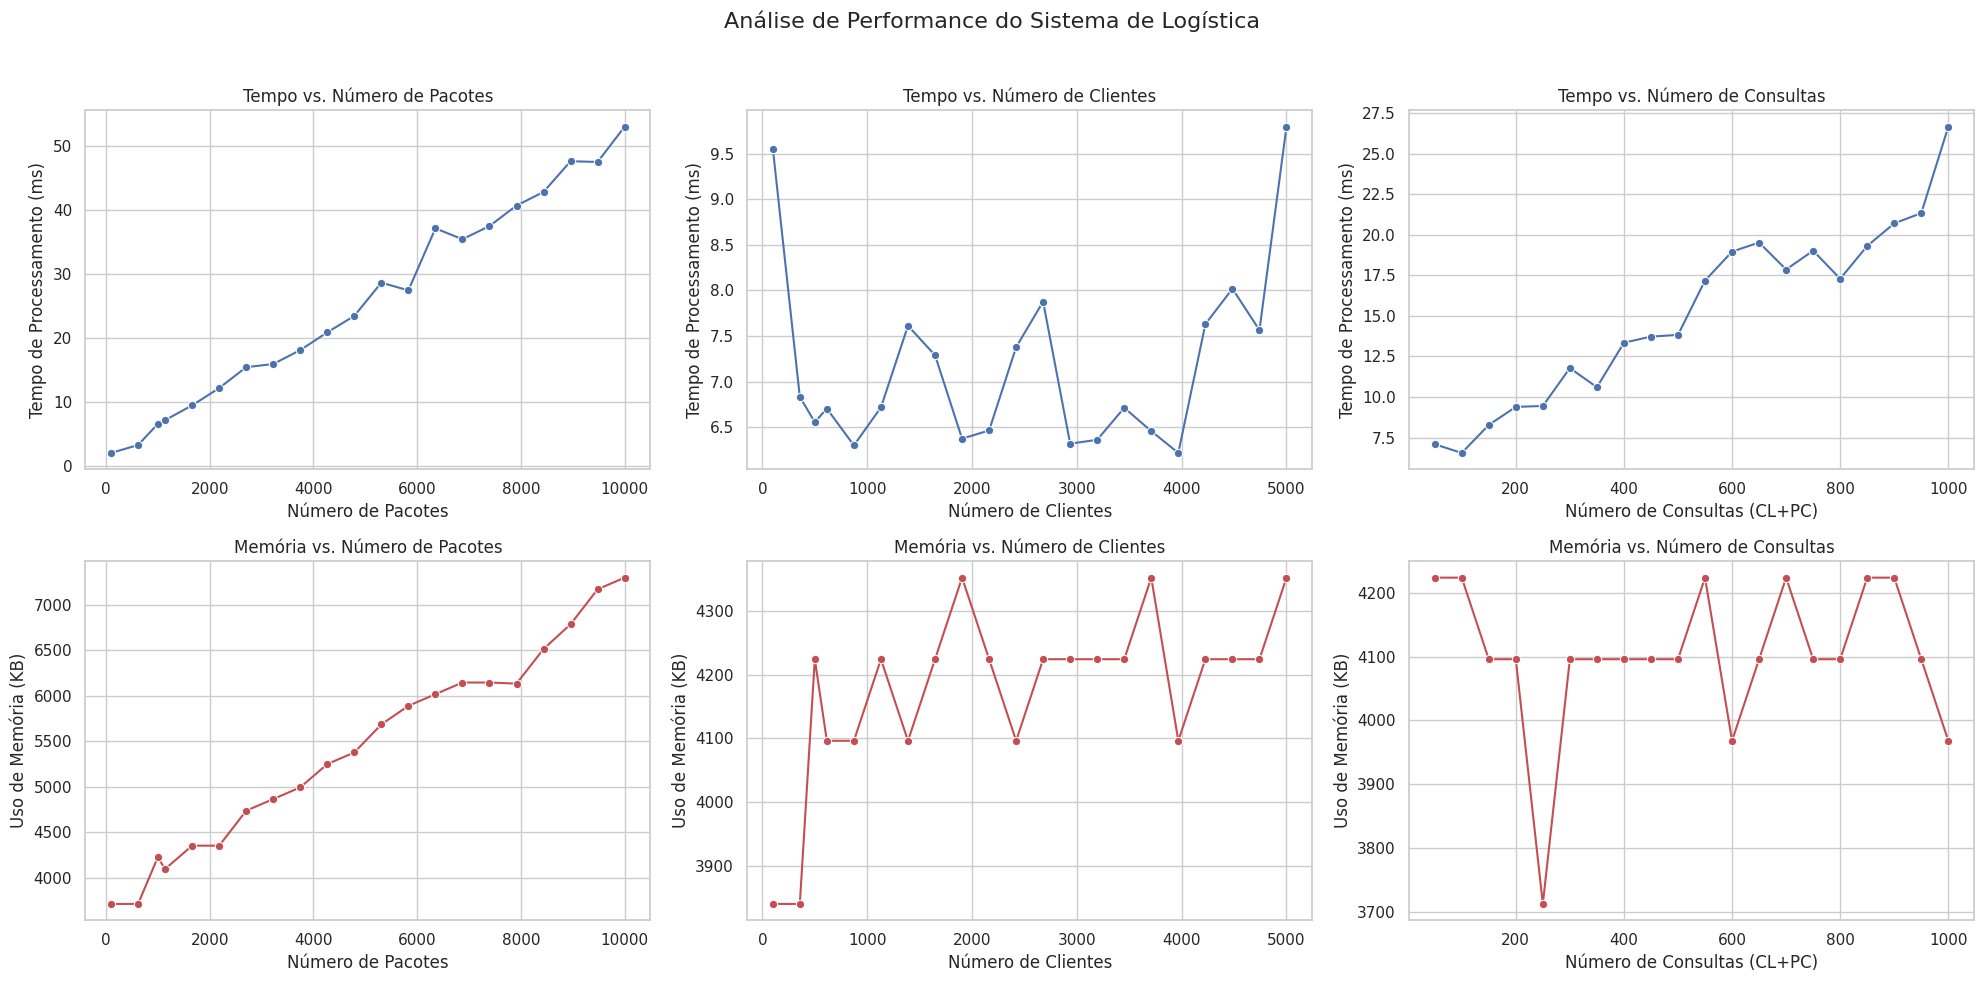

In [4]:
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle('Análise de Performance do Sistema de Logística', fontsize=16)

# Gráficos para variação de Pacotes
df_packets = df_results[(df_results['clients'] == base_params['clients']) & (df_results['num_cl'] == base_params['num_cl'])]
sns.lineplot(ax=axes[0, 0], data=df_packets, x='packets', y='time_ms', marker='o')
axes[0, 0].set_title('Tempo vs. Número de Pacotes')
axes[0, 0].set_xlabel('Número de Pacotes')
axes[0, 0].set_ylabel('Tempo de Processamento (ms)')
sns.lineplot(ax=axes[1, 0], data=df_packets, x='packets', y='memory_kb', marker='o', color='r')
axes[1, 0].set_title('Memória vs. Número de Pacotes')
axes[1, 0].set_xlabel('Número de Pacotes')
axes[1, 0].set_ylabel('Uso de Memória (KB)')

# Gráficos para variação de Clientes
df_clients = df_results[(df_results['packets'] == base_params['packets']) & (df_results['num_cl'] == base_params['num_cl'])]
sns.lineplot(ax=axes[0, 1], data=df_clients, x='clients', y='time_ms', marker='o')
axes[0, 1].set_title('Tempo vs. Número de Clientes')
axes[0, 1].set_xlabel('Número de Clientes')
axes[0, 1].set_ylabel('Tempo de Processamento (ms)')
sns.lineplot(ax=axes[1, 1], data=df_clients, x='clients', y='memory_kb', marker='o', color='r')
axes[1, 1].set_title('Memória vs. Número de Clientes')
axes[1, 1].set_xlabel('Número de Clientes')
axes[1, 1].set_ylabel('Uso de Memória (KB)')

# Gráficos para variação de Consultas
df_queries = df_results[(df_results['packets'] == base_params['packets']) & (df_results['clients'] == base_params['clients'])]
sns.lineplot(ax=axes[0, 2], data=df_queries, x='num_cl', y='time_ms', marker='o')
axes[0, 2].set_title('Tempo vs. Número de Consultas')
axes[0, 2].set_xlabel('Número de Consultas (CL+PC)')
axes[0, 2].set_ylabel('Tempo de Processamento (ms)')
sns.lineplot(ax=axes[1, 2], data=df_queries, x='num_cl', y='memory_kb', marker='o', color='r')
axes[1, 2].set_title('Memória vs. Número de Consultas')
axes[1, 2].set_xlabel('Número de Consultas (CL+PC)')
axes[1, 2].set_ylabel('Uso de Memória (KB)')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()